In [3]:
from dataset_evaluation import (sentence_level_quality,
                                entity_level_quality,
                                pipeline_prediction,
                                fidelity)


import dataset_evaluation as dse
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import seaborn as sns
import os
import json
from datasets import load_dataset
import random

# Annotated dataset


### Fidelity


On the real data :

In [8]:
vacancies = pd.read_csv("../../data/processed/real/job_offers_compound_2.csv")

metric = fidelity(list(vacancies["enhanced_sentences"]), model_id="gpt2")

Using pad_token, but it is not set yet.


  0%|          | 0/76 [00:00<?, ?it/s]

In [10]:
annot_fidelity = metric["mean_perplexity"]
annot_fidelity

111.46399115887662

### ELQ

In [5]:
test = pd.read_csv("https://raw.githubusercontent.com/jensjorisdecorte/Skill-Extraction-benchmark/main/tech_test_annotations.csv")
multilabel = test.groupby("sentence").agg({"label": lambda x : x.tolist() , "span": lambda x : x.tolist()}).reset_index()
annotated_records = multilabel.to_dict(orient='records')

In [ ]:
if(os.path.isfile("preds.json")):
    print("> Loading precomputed results")
    with open('preds.json', 'w') as f:
        pip_annot_predictions = json.load(f)
else :
    print("> Computing predictions")
    pip_annot_predictions = pipeline_prediction(annotated_records)
    with open('preds.json', 'w') as f:
        json.dump(pip_annot_predictions, f)

In [18]:
pip_annot_ELQ = entity_level_quality(pip_annot_predictions[0])
pip_annot_ELQ

new


  0%|          | 0/425 [00:00<?, ?it/s]

[[['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Solidity'], []], [['analyse business requirements', 'communicate with stakeholders'], ['ability to analyse requirements']], [['manage a team', 'lead others', 'mentor individuals', 'coach employees'], []], [['work in teams', 'meet commitments', 'work in teams', 'meet commitments'], ['ability to work in large collaborative teams']], [['work in teams', 'meet commitments', 'think innovately', 'work in teams', 'meet commitments', 'think innovately'], []], [['information architecture', 'LABEL NOT PRESENT'], ['architecture and design across all systems']], [['deploy cloud resource', 'deploy cloud resource'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['designing and building reusable services']], [['database', 'data extraction, transformation and loading tools'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABE

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'1_to_1': {'accuracy': 0.05934718100890208,
  'precision_micro': 0.05934718100890208,
  'precision_macro': 0.048724972176299605,
  'recall_micro': 0.05934718100890208,
  'recall_macro': 0.041817930121123656,
  'F1_micro': 0.05934718100890208,
  'F1_macro': 0.04500800018380189},
 'many_to_many': {'jaccard_accuracy': 0.000784313725490196}}

### SLQ

In [22]:
annot_SLQ = sentence_level_quality(pd.DataFrame(annotated_records).explode("label"))

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/1164 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


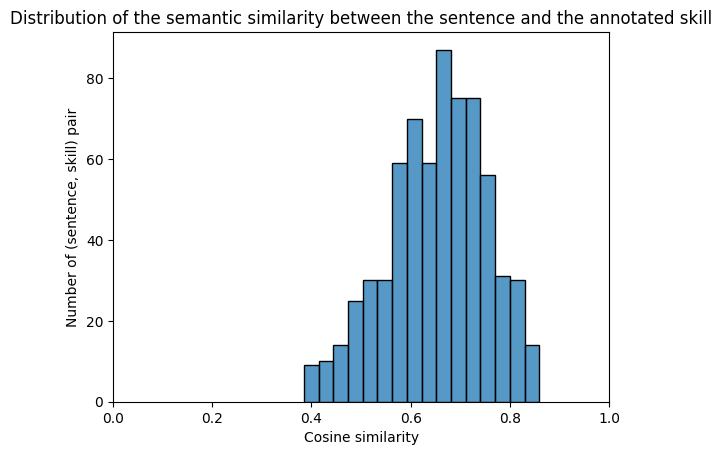

In [28]:
g = sns.histplot(data=annot_SLQ.reset_index(), x="sim")
g.set_xlim((0, 1))
g.set_title("Distribution of the semantic similarity between the sentence and the annotated skill")
g.set_xlabel("Cosine similarity")
g.set_ylabel("Number of (sentence, skill) pair");

In [27]:
annot_SLQ_metrics = {
    'mean': annot_SLQ.sim.mean(),
    'median': annot_SLQ.sim.median(),
    'var': annot_SLQ.sim.var()
}

### Conlusion

In [ ]:
metrics = {
    "annotated" : {
        "fidelity" : annot_fidelity,
        "SLQ": annot_SLQ_metrics,
        "pip_ELQ": pip_annot_ELQ,
    }
}

# Synthetic dataset

In [20]:
ds = load_dataset("jensjorisdecorte/Synthetic-ESCO-skill-sentences")["train"]

### Fidelity

In [14]:
metric = fidelity(ds["sentence"], model_id="gpt2")

Using pad_token, but it is not set yet.


  0%|          | 0/8642 [00:00<?, ?it/s]

In [15]:
synth_fidelity = metric["mean_perplexity"]
synth_fidelity

104.67401827280452

### ELQ

In [21]:
synth_ds = pd.DataFrame(ds)
csynth_ds = synth_ds.groupby("sentence").agg({'skill' : lambda x: x.tolist()}).reset_index()
csynth_records = csynth_ds.to_dict(orient='records')

In [35]:
if(os.path.isfile("preds_synth.json")):
    print("> Loading precomputed results")
    with open('preds_synth.json', 'w') as f:
        pip_synth_predictions = json.load(f)
else :
    print("> Computing predictions")
    subs_csr = random.sample(csynth_records, 452)
    pip_synth_predictions = pipeline_prediction(annotated_records)
    with open('preds_synth.json', 'w') as f:
        json.dump(pip_synth_predictions, f)

> Computing predictions


In [31]:
pip_synth_ELQ = entity_level_quality(pip_synth_predictions[0], label_key="skill")

new


  0%|          | 0/452 [00:00<?, ?it/s]

[[['implement ICT risk management'], []], [['supervise pool activities'], []], [['personal directing styles'], ['directing, including personal directing styles']], [['assess your competencies in leading community arts'], []], [['design weft knitted fabrics'], []], [['attach lift motor cables'], []], [['serve beverages'], ['drinks']], [['follow signalling instructions'], ['experience in following signalling instructions']], [['pollution legislation'], ['monitoring and evaluating the impact of pollution on the environment']], [['teach basic numeracy skills'], ['develop and improve the basic numeracy skills of students']], [['run errands on behalf of customers'], ['reliable transportation', 'flexible schedule']], [['fabric types'], []], [['types of pulp'], []], [['understand artistic concepts'], ['artistic process', 'communicating it to others']], [['perform metal active gas welding'], []], [['follow procedures in the event of an alarm'], ['procedures in the event of an alarm']], [['compi

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
pip_synth_ELQ

{'1_to_1': {'accuracy': 0.16150442477876106,
  'precision_micro': 0.16150442477876106,
  'precision_macro': 0.12080536912751678,
  'recall_micro': 0.16150442477876106,
  'recall_macro': 0.12164429530201343,
  'F1_micro': 0.16150442477876106,
  'F1_macro': 0.12122338078539746},
 'many_to_many': {'jaccard_accuracy': 0.017699115044247787}}

### SLQ

In [13]:
synth_SLQ = sentence_level_quality(synth_ds[:10_000], label_key="skill")

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10000 [00:00<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/SkillThrills/protosp01/dataset_generation/dataset_evaluation.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["embeddings"] = dataset["sentence"]\
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/SkillThrills/protosp01/dataset_generation/dataset_evaluation.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["embeddings"] = dataset["embeddings"].apply(lambda x : x.detach())


  0%|          | 0/10000 [00:02<?, ?it/s]

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/SkillThrills/protosp01/dataset_generation/dataset_evaluation.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["sim"] = dataset[["embeddings", label_key]].progress_apply(compute_cos_sim, axis=1)


/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


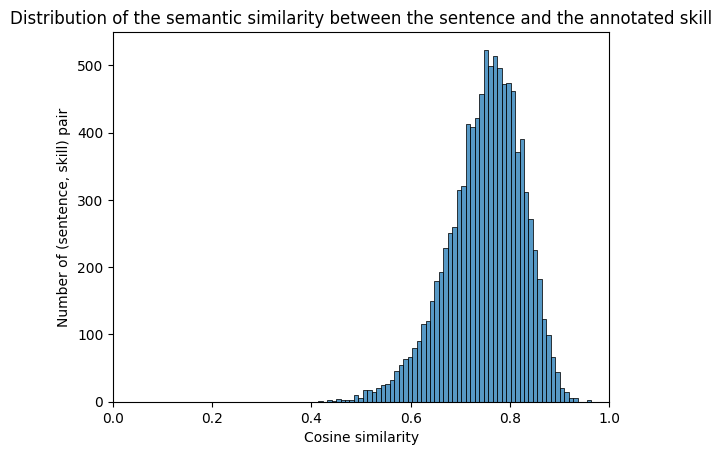

In [14]:
g = sns.histplot(data=synth_SLQ.reset_index(), x="sim")
g.set_xlim((0, 1))
g.set_title("Distribution of the semantic similarity between the sentence and the annotated skill")
g.set_xlabel("Cosine similarity")
g.set_ylabel("Number of (sentence, skill) pair");

In [25]:
l = [[['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Solidity'], []], [['analyse business requirements', 'communicate with stakeholders'], ['ability to analyse requirements']], [['manage a team', 'lead others', 'mentor individuals', 'coach employees'], []], [['work in teams', 'meet commitments', 'work in teams', 'meet commitments'], ['ability to work in large collaborative teams']], [['work in teams', 'meet commitments', 'think innovately', 'work in teams', 'meet commitments', 'think innovately'], []], [['information architecture', 'LABEL NOT PRESENT'], ['architecture and design across all systems']], [['deploy cloud resource', 'deploy cloud resource'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['designing and building reusable services']], [['database', 'data extraction, transformation and loading tools'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], []], [['application process', 'manage ICT data architecture', 'information architecture', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'ICT infrastructure'], []], [['Java (computer programming)', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['control financial resources', 'manage budgets'], ['keen understanding of financial control and budget management']], [['UNDERSPECIFIED'], ['knowledge of big data/nosql solutions']], [['R', 'Python (computer programming)', 'machine learning', 'data storage'], []], [['DevOps', 'LABEL NOT PRESENT'], ['devops', 'ci/cd automation']], [['solution deployment', 'UNDERSPECIFIED', 'UNDERSPECIFIED'], ['deployment approaches considerations and challenges of managing deployments across various environments']], [['LABEL NOT PRESENT', 'analyse financial performance of a company'], []], [['LABEL NOT PRESENT', 'UNDERSPECIFIED'], []], [['monitor technology trends', 'LABEL NOT PRESENT', 'monitor technology trends', 'LABEL NOT PRESENT'], ['industry-wide technology trends and best practices']], [['LABEL NOT PRESENT'], []], [['think innovately'], []], [['computer programming'], []], [['LABEL NOT PRESENT', 'manage relationships with stakeholders'], []], [['Java (computer programming)', 'LABEL NOT PRESENT'], ['java (version 8 or higher)']], [['UNDERSPECIFIED', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['business analysis', 'UNDERSPECIFIED', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['develop automated software tests', 'Java (computer programming)'], []], [['Visual Studio .NET', 'LABEL NOT PRESENT'], ['.net development experience']], [['LABEL NOT PRESENT'], []], [['Visual Studio .NET', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Visual Studio .NET', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['Visual Studio .NET', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Visual Studio .NET', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED'], []], [['attend to detail', 'meet expectations of target audience', 'LABEL NOT PRESENT'], []], [['show determination'], ['get-things-done attitude']], [['LABEL NOT PRESENT'], []], [['ASP.NET', 'LABEL NOT PRESENT'], []], [['solve problems', 'manage a team', 'gather data', 'LABEL NOT PRESENT', 'present reports', 'LABEL NOT PRESENT'], ['frame problems', 'present the data to influence leadership']], [['LABEL NOT PRESENT'], []], [['ICT accessibility standards', 'application usability', 'World Wide Web Consortium standards'], ['accessibility, usability, and adherence to current web standards']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['architectural design', 'manage ICT data architecture', 'ICT infrastructure'], []], [['scientific modelling', 'LABEL NOT PRESENT'], ['affinity for statistical modeling and optimization problems']], [['Agile development'], ['agile']], [['Agile project management'], ['agile method practice']], [['Agile development', 'financial engineering'], []], [['aesthetics', 'LABEL NOT PRESENT'], ['eye for aesthetics design']], [['LABEL NOT PRESENT', 'draw up risk assessment'], ['analysis and risk assessment']], [['define software architecture'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'UNDERSPECIFIED', 'provide documentation', 'software architecture models'], ['design modelling documentation']], [['LABEL NOT PRESENT', 'aesthetics'], ['aesthetic know-how']], [['make decisions'], ['right decisions early enough in the project']], [['principles of artificial intelligence', 'machine learning', 'UNDERSPECIFIED'], []], [['develop new products'], []], [['manage standard enterprise resource planning system', 'LABEL NOT PRESENT'], []], [['show commitment', 'show professional responsibility'], []], [['solve problems', 'seek innovation in current practices', 'engineering processes'], []], [['liaise with engineers', 'collaborate with designers', 'work with an artistic team'], []], [['propose ICT solutions to business problems', 'innovation processes', 'engineering principles'], ['passionate about solving business problems through innovation & engineering practices']], [['propose ICT solutions to business problems', 'innovation processes', 'engineering principles'], ['passionate about solving business problems through innovation and engineering practices']], [['computer engineering', 'assist customers'], []], [['collaborate with engineers'], []], [['assertiveness', 'think proactively'], ['assertive']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'UNDERSPECIFIED', 'LABEL NOT PRESENT', 'software architecture models', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'Unity (digital game creation systems)', 'C#'], []], [['LABEL NOT PRESENT'], []], [['industrial software', 'define software architecture', 'design information system', 'define software architecture'], ['software/system design and architecture']], [['C#', 'LABEL NOT PRESENT', 'TypeScript'], []], [['perform project management'], ['realize exciting projects in a team']], [['levels of software testing', 'UNDERSPECIFIED', 'UNDERSPECIFIED'], ['testing at various levels in an agile environment', 'test automation']], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'apply information security policies'], []], [['UNDERSPECIFIED', 'use geographic information systems'], ['location-based services']], [['LABEL NOT PRESENT'], ['technical talent', 'drive to produce outstanding work']], [['C#', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['tools for ICT test automation', 'UNDERSPECIFIED'], []], [['implement ICT coding conventions'], ['clear and easy-to-maintain code']], [['cloud technologies'], []], [['cloud technologies', 'computer technology', 'provide technical expertise'], []], [['architectural design', 'lead a team', 'lead a team', 'lead a team', 'UNDERSPECIFIED'], ['coach, guide, and mentor teams']], [['conduct ICT code review'], ['code reviews']], [['DevOps', 'LABEL NOT PRESENT', 'develop test procedures', 'LABEL NOT PRESENT'], []], [['liaise with shareholders', 'systems development life-cycle'], []], [['UNDERSPECIFIED', 'identify technological needs', 'LABEL NOT PRESENT', 'manage technical resources stock'], ['architects and senior developers']], [['use online tools to collaborate', 'LABEL NOT PRESENT', 'Open source model'], []], [['work in teams', 'apply technical communication skills'], ['collaboration in project teams', 'communication with technical customer departments']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['communicate strategies and processes']], [['computer technology', 'database', 'use IT tools'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'design engineering components', 'UNDERSPECIFIED'], []], [['engineering processes', 'solve technical problems'], ['planning and organization']], [['manage quality', 'execute software tests', 'LABEL NOT PRESENT'], ['code']], [['video-games functionalities', 'LABEL NOT PRESENT'], []], [['create incident reports', 'analyse work-related written reports', 'process incident reports for prevention'], ['creation, analysis, and processing of error reports']], [['develop automated software tests', 'develop automated software tests', 'develop automated software tests', 'LABEL NOT PRESENT'], ['creation, maintenance, execution, and documentation of (automated) tests']], [['cyber security', 'manage data', 'web analytics', 'digital marketing techniques'], []], [['UNDERSPECIFIED'], []], [['create data models'], []], [['perform data analysis', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['Java (computer programming)', 'LABEL NOT PRESENT', 'web programming', 'database', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'distributed directory information services', 'distributed directory information services', 'LABEL NOT PRESENT', 'design application interfaces', 'design application interfaces', 'LABEL NOT PRESENT'], ['java spring framework']], [['LABEL NOT PRESENT', 'computer science'], []], [['computer science', 'UNDERSPECIFIED', 'Angular', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['provide technical expertise', 'provide high quality customer service', 'solve problems', 'maintain relationship with customers', 'build business relationships'], []], [['design process', 'LABEL NOT PRESENT'], ['designing and documenting']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'implement front-end website design', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['front-end/bi layer']], [['LABEL NOT PRESENT', 'UNDERSPECIFIED'], []], [['UNDERSPECIFIED', 'LABEL NOT PRESENT', 'Visual Studio .NET', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['DevOps'], []], [['LABEL NOT PRESENT', 'data extraction, transformation and loading tools', 'use databases', 'data extraction, transformation and loading tools'], ["etl pipelines to integrate our customers' databases"]], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'computer engineering', 'manage the customer experience'], []], [['provide documentation'], ['documentation']], [['financial forecasting', 'LABEL NOT PRESENT'], []], [['Agile project management', 'LABEL NOT PRESENT'], ['agile & energetic startup environment']], [['communication', 'English'], ['oral and written english communication skills']], [['LABEL NOT PRESENT'], ['english proficiency']], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'conduct ICT code review', 'UNDERSPECIFIED', 'quality assurance procedures', 'LABEL NOT PRESENT', 'UNDERSPECIFIED', 'quality standards'], []], [['LABEL NOT PRESENT'], []], [['quality assurance procedures'], []], [['entertainment industry', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['mathematics', 'LABEL NOT PRESENT', 'UNDERSPECIFIED'], ['3d game programming knowledge']], [['create prototype of user experience solutions', 'LABEL NOT PRESENT'], ['ux']], [['communication', 'offer financial services'], []], [['analyse business objectives', 'LABEL NOT PRESENT'], ['specific goals']], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['computer programming'], []], [['quality assurance methodologies'], ['quality assurance']], [['perform ICT troubleshooting'], ['troubleshooting it infrastructure related issues']], [['develop test procedures', 'Objective-C', 'Java (computer programming)'], ['tdd (test driven development)']], [['LABEL NOT PRESENT', 'UNDERSPECIFIED', 'Agile development'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], []], [['use an application-specific interface', 'use an application-specific interface'], []], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'LABEL NOT PRESENT', 'perform ICT troubleshooting'], ['troubleshooting large-scale distributed systems']], [['offer financial services', 'offer financial services', 'offer financial services'], []], [['offer financial services', 'LABEL NOT PRESENT', 'follow reporting procedures'], []], [['LABEL NOT PRESENT'], []], [['English'], ['fluent english']], [['English', 'German'], []], [['create solutions to problems'], []], [['identify requirements of the work', 'interpret technical requirements', 'LABEL NOT PRESENT', 'create solutions to problems', 'design prototypes', 'LABEL NOT PRESENT', 'assess risk factors', 'assess project resource needs', 'communicate analytical insights', 'communicate performance aspects', 'LABEL NOT PRESENT', 'security threats'], []], [['aesthetics'], ['good aesthetic know-how']], [['work in teams', 'teamwork principles'], ['guidance and support']], [['LABEL NOT PRESENT', 'LESS', 'LABEL NOT PRESENT'], ['css']], [['conduct performance tests', 'perform software unit testing', 'execute integration testing', 'develop test procedures', 'LABEL NOT PRESENT', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['tools for ICT test automation'], []], [['identify talent'], []], [['manage quality', 'LABEL NOT PRESENT'], ['quality']], [['LABEL NOT PRESENT'], []], [['UNDERSPECIFIED', 'assume responsibility'], []], [['LABEL NOT PRESENT'], []], [['identify problems', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], ['promising solutions to production']], [['LABEL NOT PRESENT'], []], [['video-games functionalities', 'design user interface'], ['user interfaces']], [['software frameworks'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['.net webapi']], [['implement front-end website design'], []], [['adapt developed game to the market', 'design the physical outlook of games', 'design the physical outlook of games', 'Unity (digital game creation systems)'], []], [['C#', 'LABEL NOT PRESENT', 'TypeScript'], ['c', 'f', 'typescript']], [['LABEL NOT PRESENT', 'computer programming', 'LABEL NOT PRESENT'], ['coding skills with kotlin']], [['tools for ICT test automation'], []], [['emergent technologies'], []], [['Agile development', 'financial engineering'], []], [['principles of artificial intelligence', 'machine learning', 'UNDERSPECIFIED'], []], [['cloud technologies', 'use IT tools', 'provide technical expertise'], []], [['use online tools to collaborate', 'LABEL NOT PRESENT', 'Open source model'], []], [['computer engineering', 'database', 'use IT tools'], []], [['cyber security', 'manage data', 'web analytics', 'digital marketing techniques'], []], [['LABEL NOT PRESENT', 'cyber security', 'computer engineering'], []], [['UNDERSPECIFIED', 'computer engineering', 'manage the customer experience'], ['digital agency']], [['entertainment industry', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['offer financial services', 'offer financial services', 'offer financial services'], []], [['offer financial services', 'financial engineering', 'prepare compliance documents'], []], [['financial engineering'], []], [['computer technology', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], []], [['e-commerce systems', 'digital marketing techniques'], []], [['e-commerce systems', 'pricing strategies', 'UNDERSPECIFIED'], []], [['use IT tools', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'demonstrate loyalty', 'LABEL NOT PRESENT'], ['payment loyalty and shopping']], [['machine learning', 'cloud technologies', 'design application interfaces'], ['machine learning']], [['work independently', 'keep an open mind', 'assertiveness', 'cooperate with colleagues', 'create solutions to problems'], ['critical (in a constructive way of course)']], [['Java (computer programming)', 'Python (computer programming)', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['tools for ICT test automation', 'tools for ICT test automation', 'tools for ICT test automation'], []], [['C#', 'Visual Studio .NET', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'object-oriented modelling', 'LABEL NOT PRESENT'], ['t-sql (ms sql server)', 'object-oriented design']], [['supervise work on design planning', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['sell products to our end customers']], [['manage the customer experience'], []], [['solve technical problems'], ['solving technical challenges']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['google awareness api']], [['manage work', 'meet deadlines', 'manage work'], ['manage individual priorities, deadlines, and deliverables']], [['automation technology'], []], [['UNDERSPECIFIED'], []], [['build networks', 'communication', 'present arguments persuasively', 'present arguments persuasively', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'PostgreSQL'], []], [['train crew members'], ['onboard new colleagues']], [['JavaScript', 'LABEL NOT PRESENT', 'Angular', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['vue']], [['liaise with shareholders'], ['openness to work with many different stakeholders']], [['LABEL NOT PRESENT', 'SQL', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['design user interface'], []], [['Unity (digital game creation systems)', 'LABEL NOT PRESENT', 'Unity (digital game creation systems)', 'C#'], []], [['attend meetings', 'LABEL NOT PRESENT', 'conduct ICT code review'], ['code reviews']], [['create a work atmosphere of continuous improvement', 'seek innovation in current practices'], ['continuous exploration and innovation']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['development of new features']], [['LABEL NOT PRESENT'], ['performant and rigid systems']], [['Agile development', 'develop new products', 'LABEL NOT PRESENT'], []], [['think innovately'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['execute software tests', 'conduct ICT code review', 'provide technical documentation'], []], [['work efficiently'], ['personal efficiency']], [['Android (mobile operating systems)'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['planning test activities']], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], ['presentation skills']], [['adapt developed game to the market', 'LABEL NOT PRESENT'], []], [['computer engineering'], ['university degree in computer engineering or equivalent']], [['think analytically', 'solve problems'], ['good analytical and problem-solving skills']], [['Java (computer programming)', 'R'], ['java']], [['LABEL NOT PRESENT', 'produce customised tools', 'UNDERSPECIFIED', 'LABEL NOT PRESENT', 'C#'], []], [['LABEL NOT PRESENT', 'create technical plans', 'information architecture'], ['high-level technical design strategy roadmap development']], [['computer programming', 'Python (computer programming)'], ['back-end programming skills']], [['LABEL NOT PRESENT'], []], [['analyse issues', 'provide documentation'], ['reporting and documenting']], [['UNDERSPECIFIED'], ['reporting the results']], [['LABEL NOT PRESENT', 'analyse business requirements', 'define technical requirements'], ['requirements capture/analysis and documentation']], [['UNDERSPECIFIED'], []], [['define software architecture'], ['describing a solution architecture']], [['execute software tests'], ['running tests on new code']], [['SQL', 'SQL Server', 'JavaScript'], []], [['Agile development'], []], [['solve problems', 'innovation processes', 'engineering principles'], []], [['LABEL NOT PRESENT', 'UNDERSPECIFIED'], ['architecture knowledge findings and standard methodologies']], [['promote the transfer of knowledge', 'manage quality', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'coaching techniques'], ['share knowledge']], [['distributed computing', 'distributed computing', 'design application interfaces', 'design application interfaces'], []], [['UNDERSPECIFIED'], ['sound tech experience of agile/lean methodologies']], [['LABEL NOT PRESENT', 'mentor individuals', 'manage quality'], []], [['LABEL NOT PRESENT'], ['software development']], [['systems thinking', 'architectural theory'], []], [['apply strategic thinking', 'think analytically', 'think critically'], ['analytical and critical thinking skills']], [['manage quality', 'LABEL NOT PRESENT'], ['code quality', 'clean code']], [['database management systems', 'LABEL NOT PRESENT', 'Python (computer programming)', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['database structures']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'quality assurance procedures'], ['software qa methodologies, tools, and processes']], [['work in an organised manner', 'LABEL NOT PRESENT', 'demonstrate willingness to learn', 'communication', 'LABEL NOT PRESENT'], ['independent cooperation']], [['computer science'], []], [['LABEL NOT PRESENT', 'liaise with colleagues', 'LABEL NOT PRESENT'], ['technical orientation', 'technical alternatives']], [['work in teams', 'LABEL NOT PRESENT', 'UNDERSPECIFIED', 'solve problems'], []], [['work in teams', 'German', 'work in teams', 'English'], ['german and english (both spoken and written)']], [['attend to detail', 'LABEL NOT PRESENT', 'solve problems', 'communication'], ['teamwork', 'resourcefulness', 'problem solving']], [['LABEL NOT PRESENT', 'engage in debates', 'make decisions'], []], [['advise client on technical possibilities'], ['technical advice']], [['UNDERSPECIFIED', 'analyse test data'], ['testing', 'analysis of test results']], [['identify service requirements', 'UNDERSPECIFIED'], []], [['computer science', 'computer engineering'], []], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'UNDERSPECIFIED', 'UNDERSPECIFIED'], ['delivery to business (d2b)']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'work independently'], []], [['develop automated software tests', 'assess reliability of data', 'UNDERSPECIFIED', 'visual presentation techniques'], ['data integrity, performance, and presentation quality']], [['oversee development of software'], []], [['LABEL NOT PRESENT', 'innovation processes'], ['willingness to familiarize yourself with new technologies', 'innovations']], [['LABEL NOT PRESENT', 'identify requirements of the work'], []], [['UNDERSPECIFIED', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['accept own accountability', 'assume responsibility', 'LABEL NOT PRESENT', 'assume responsibility', 'show determination'], []], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'UNDERSPECIFIED'], ['intuition for designing ui and ux']], [['LABEL NOT PRESENT', 'identify processes for re-engineering'], ['transition and re-engineering']], [['solve ICT system problems', 'recommend product improvements', 'LABEL NOT PRESENT'], ['troubleshoot issues']], [['troubleshoot', 'debug software'], ['troubleshooting and debugging code']], [['LABEL NOT PRESENT', 'web programming'], ['microsoft / web development environment']], [['LABEL NOT PRESENT'], []], [['English'], ['english comprehension']], [['solve technical problems', 'manage quality'], []], [['LABEL NOT PRESENT', 'develop automated software tests'], ['continuous integration']], [['LABEL NOT PRESENT', 'UNDERSPECIFIED'], []], [['think creatively'], []], [['logging'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['cypress, jest, nunit, specflow, expecto, fscheck, and canopy']], [['LABEL NOT PRESENT'], ['log business metrics']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['communication', 'provide documentation'], ['effective communication and documentation']], [['address an audience', 'communicate with target community'], ['engage in the community']], [['UNDERSPECIFIED', 'UNDERSPECIFIED'], []], [['liaise with engineers', 'liaise with engineers'], ['machine learning developers']], [['UNDERSPECIFIED', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'analyse business requirements', 'draft design specifications', 'UNDERSPECIFIED'], ['elicit requirements', 'developing design specifications']], [['UNDERSPECIFIED'], []], [['create solutions to problems', 'ICT system programming', 'UNDERSPECIFIED'], []], [['develop product design'], []], [['authoring software', 'software frameworks'], ['writing software']], [['LABEL NOT PRESENT'], ['solid data and metrics']], [['LABEL NOT PRESENT', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], ['architect, build, and maintain']], [['architectural design', 'design principles'], []], [['demonstrate trustworthiness', 'demonstrate trustworthiness', 'maintain internal communication systems'], ['communicates openly']], [['German', 'English'], []], [['Java (computer programming)'], []], [['English'], []], [['LABEL NOT PRESENT'], []], [['think holistically'], ['connect complex issues']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['quality standards'], []], [['LABEL NOT PRESENT', 'identify requirements of the work', 'advise others', 'advise others'], []], [['LABEL NOT PRESENT'], []], [['design information system', 'information structure', 'algorithms'], []], [['emergent technologies', 'LABEL NOT PRESENT', 'database', 'cloud technologies', 'LABEL NOT PRESENT', 'analyse big data'], ['restful api']], [['LABEL NOT PRESENT', 'design application interfaces'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Ansible', 'LABEL NOT PRESENT'], ['ansible']], [['LABEL NOT PRESENT'], ['development methodologies']], [['conduct performance measurement', 'UNDERSPECIFIED'], []], [['LABEL NOT PRESENT', 'develop automated software tests', 'develop automated software tests'], ['quality, testability, and automation']], [['JavaScript', 'TypeScript', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'perform software unit testing', 'develop automated software tests', 'execute integration testing'], ['javascript', 'typescript', 'node.js']], [['LABEL NOT PRESENT', 'Python (computer programming)'], []], [['Agile project management', 'LABEL NOT PRESENT'], []], [['troubleshoot'], ['troubleshooting skills']], [['communication principles', 'practice humour'], []], [['promote the transfer of knowledge'], []], [['identify problems'], ['identify shortcomings quickly', 'making them better']], [['LABEL NOT PRESENT', 'integrate system components', 'administer ICT system', 'DevOps'], ['devops', 'build, implement, and operate a system']], [['cope with challenging demands', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'develop creative ideas', 'LABEL NOT PRESENT'], []], [['English'], []], [['communication'], []], [['manage quality'], []], [['quality assurance methodologies'], []], [['UNDERSPECIFIED', 'LABEL NOT PRESENT', 'systems development life-cycle', 'use software design patterns', 'LABEL NOT PRESENT', 'execute software tests'], []], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'engage with stakeholders', "identify with the company's goals", 'UNDERSPECIFIED', 'UNDERSPECIFIED', 'engage with stakeholders', 'meet commitments', 'systems development life-cycle'], ['partner continuously with stakeholders']], [['perform product planning'], ['product launch']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED'], []], [['LABEL NOT PRESENT'], ['exploratory/manual tests']], [['develop test procedures', 'LABEL NOT PRESENT'], ['test plans and test cases']], [['develop test procedures', 'develop ICT test suite'], ['testing standards and strategies']], [['develop automated software tests', 'develop automated software tests', 'execute software tests'], ['design, develop, and execute automatic tests']], [['LABEL NOT PRESENT'], []], [['identify problems', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], []], [['liaise with colleagues', 'liaise with managers', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'UNDERSPECIFIED'], ['functional and non-functional requirements', 'design and implementation']], [['liaise with colleagues', 'develop automated software tests', 'monitor ticketing', 'product data management'], []], [['LABEL NOT PRESENT'], []], [['demonstrate willingness to learn'], []], [['work independently', "identify with the company's goals", "identify with the company's goals"], ['autonomously']], [['LABEL NOT PRESENT', 'cooperate with colleagues'], []], [['LABEL NOT PRESENT', 'develop with cloud services'], []], [['manage quality'], ['quality']], [['UNDERSPECIFIED', 'UNDERSPECIFIED', 'manage relationships with stakeholders', "identify with the company's goals", 'UNDERSPECIFIED', 'UNDERSPECIFIED', 'manage relationships with stakeholders', "identify with the company's goals", 'systems development life-cycle'], ['partner continuously with stakeholders']], [['UNDERSPECIFIED'], ['integral application to interface across several other governmental departments']], [['UNDERSPECIFIED', 'UNDERSPECIFIED'], ['workflows and tooling']], [['demonstrate curiosity'], []], [['use functional programming'], []], [['design cloud architecture', 'LABEL NOT PRESENT'], []], [['listen actively', 'LABEL NOT PRESENT'], ['explain concepts to others']], [['personal development'], []], [['UNDERSPECIFIED', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['assume responsibility', 'demonstrate willingness to learn'], []], [['design application interfaces', 'LABEL NOT PRESENT'], []], [['German', 'English'], ['german', 'english']], [['tools for ICT test automation', 'LABEL NOT PRESENT'], []], [['total quality control'], []], [['solve problems', 'emergent technologies'], ['problem solver', 'curious about new technology']], [['UNDERSPECIFIED', 'software architecture models', 'UNDERSPECIFIED', 'software architecture models'], ['agile architecture']], [['Android (mobile operating systems)', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'Visual Studio .NET', 'C#', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Visual Studio .NET', 'C#', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['UNDERSPECIFIED', 'e-commerce systems'], []], [['create new concepts', 'LABEL NOT PRESENT'], []], [['C#', 'LABEL NOT PRESENT', 'TypeScript', 'C#', 'LABEL NOT PRESENT', 'TypeScript'], []], [['C#', 'TypeScript', 'LABEL NOT PRESENT', 'LESS', 'SQL Server', 'C#', 'TypeScript', 'LABEL NOT PRESENT', 'LESS', 'SQL Server'], []], [['cloud technologies', 'Java (computer programming)', 'LABEL NOT PRESENT', 'cloud technologies', 'Java (computer programming)', 'LABEL NOT PRESENT'], []], [['ICT system integration', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'design application interfaces'], ["development and implementation of rest api's"]], [['LABEL NOT PRESENT', 'PostgreSQL', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'PostgreSQL', 'LABEL NOT PRESENT'], []], [['e-commerce systems', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['use functional programming'], []], [['LABEL NOT PRESENT', 'UNDERSPECIFIED'], []], [['Java (computer programming)', 'algorithms', 'database', 'use concurrent programming', 'use concurrent programming', 'Java (computer programming)', 'algorithms', 'database', 'use concurrent programming', 'use concurrent programming'], []], [['Java (computer programming)', 'LABEL NOT PRESENT', 'cloud technologies', 'LABEL NOT PRESENT', 'use software design patterns', 'Java (computer programming)', 'LABEL NOT PRESENT', 'cloud technologies', 'LABEL NOT PRESENT', 'use software design patterns'], []], [['Java (computer programming)', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['Java (computer programming)', 'UNDERSPECIFIED', 'LABEL NOT PRESENT', 'Java (computer programming)', 'UNDERSPECIFIED', 'LABEL NOT PRESENT'], ['java']], [['Java (computer programming)', 'LABEL NOT PRESENT', 'Python (computer programming)', 'distributed computing', 'LABEL NOT PRESENT', 'Java (computer programming)', 'LABEL NOT PRESENT', 'Python (computer programming)', 'distributed computing', 'LABEL NOT PRESENT'], []], [['JavaScript', 'Angular', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'TypeScript', 'JavaScript', 'Angular', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'TypeScript'], []], [['LABEL NOT PRESENT', 'JavaScript', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'JavaScript', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'cloud technologies', 'create data models', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'cloud technologies', 'create data models', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'engage in debates', 'LABEL NOT PRESENT'], ['feature discussions', 'roadmap prioritization']], [['Python (computer programming)', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Python (computer programming)', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['sqlalchemy']], [['quality assurance procedures', 'automation technology', 'UNDERSPECIFIED', 'quality assurance procedures', 'automation technology', 'UNDERSPECIFIED'], []], [['quality assurance procedures', 'Python (computer programming)', 'automation technology', 'quality assurance procedures', 'Python (computer programming)', 'automation technology'], []], [['quality assurance procedures', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'quality assurance procedures', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['R', 'Java (computer programming)', 'NoSQL', 'R', 'Java (computer programming)', 'NoSQL'], []], [['test procedures', 'quality assurance procedures', 'automation technology', 'LABEL NOT PRESENT', 'develop automated software tests', 'test procedures', 'quality assurance procedures', 'automation technology', 'LABEL NOT PRESENT', 'develop automated software tests'], ['automated tests']], [['Unity (digital game creation systems)', 'C#', 'design user interface', 'Unity (digital game creation systems)', 'C#', 'design user interface'], ['user-experience']], [['develop with cloud services'], []], [['maintain relationship with customers', 'cooperate with colleagues'], ['work closely with customers and other teams']], [['mentor individuals'], []], [['apply basic programming skills'], ['high quality, testable, and efficient code']], [['develop test procedures', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['build and provide access to test environments and new features']], [['quality assurance methodologies'], []], [['develop automated software tests', 'UNDERSPECIFIED'], []], [['LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'identify problems', 'provide improvement strategies', 'LABEL NOT PRESENT'], []], [['cope with stress', 'perform failure analysis of production process'], []], [['UNDERSPECIFIED', 'computer science', 'quality assurance methodologies', 'UNDERSPECIFIED', 'quality assurance methodologies'], ['quality assurance / testing arena', 'quality assurance methods/processes and practices']], [['LABEL NOT PRESENT'], ['unix scripting']], [['apply technical communication skills', 'apply technical communication skills'], ['communicate advanced technical design and solutions']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Jenkins (tools for software configuration management)'], ['jenkins']], [['Java (computer programming)'], []], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'monitor system performance'], []], [['Agile project management', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT'], ['agile environment']], [['LABEL NOT PRESENT'], []], [['assess the life cycle of resources', 'quality assurance methodologies'], ['lifecycle principles', 'quality assurance processes and methodologies']], [['UNDERSPECIFIED', 'LABEL NOT PRESENT'], []], [['communication'], ['verbal and written skills']], [['attend to detail', 'work independently'], ['work ethic', 'independently']], [['SQL'], ['sql knowledge']], [['LABEL NOT PRESENT', 'LABEL NOT PRESENT'], []], [['application process', 'LABEL NOT PRESENT'], []], [['LABEL NOT PRESENT', 'deploy ICT systems', 'ICT system integration', 'alter management'], ['deployment', 'change management technologies']], [['solve problems', 'advise on efficiency improvements', 'operations department processes'], ['operational efficiency']], [['tools for ICT test automation'], []], [['work in teams', 'establish collaborative relations', 'meet commitments'], ['common goals']], [['Java (computer programming)', 'LABEL NOT PRESENT', 'R', 'Pentaho Data Integration', 'Oracle Relational Database', 'NoSQL', 'Agile project management'], ['nosql']]]

In [30]:
for i in l:
    print("labels :", i[0])
    print("machings :", i[1])
    print("~"*50)

labels : ['LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'LABEL NOT PRESENT', 'Solidity']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['analyse business requirements', 'communicate with stakeholders']
machings : ['ability to analyse requirements']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['manage a team', 'lead others', 'mentor individuals', 'coach employees']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['work in teams', 'meet commitments', 'work in teams', 'meet commitments']
machings : ['ability to work in large collaborative teams']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['work in teams', 'meet commitments', 'think innovately', 'work in teams', 'meet commitments', 'think innovately']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['information architecture', 'LABEL NOT PRESENT']
machings : ['architecture and design across all systems']
~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [32]:
lsy = [[['implement ICT risk management'], []], [['supervise pool activities'], []], [['personal directing styles'], ['directing, including personal directing styles']], [['assess your competencies in leading community arts'], []], [['design weft knitted fabrics'], []], [['attach lift motor cables'], []], [['serve beverages'], ['drinks']], [['follow signalling instructions'], ['experience in following signalling instructions']], [['pollution legislation'], ['monitoring and evaluating the impact of pollution on the environment']], [['teach basic numeracy skills'], ['develop and improve the basic numeracy skills of students']], [['run errands on behalf of customers'], ['reliable transportation', 'flexible schedule']], [['fabric types'], []], [['types of pulp'], []], [['understand artistic concepts'], ['artistic process', 'communicating it to others']], [['perform metal active gas welding'], []], [['follow procedures in the event of an alarm'], ['procedures in the event of an alarm']], [['compile GIS-data'], ['gis data collection and organization through software tools']], [['advise on drafting policies'], []], [['inspect casino floor'], ['inspect casino floors', 'check for proper licensing and permits', 'maintain strict security standards']], [['livestock'], ['experience in livestock breeding and genetics']], [['provide psychological support to patients'], ['mental health support and counseling']], [['dietetics'], ['knowledge of special diets']], [['manage online gambling'], ['gambling manager']], [['use solvents'], ['solvents to clean industrial machinery and equipment']], [['collect client fitness information'], []], [['monitor bushings'], []], [['keep records of work progress'], []], [['programmable logic controller'], ['experience programming and troubleshooting programmable logic controllers (plcs)']], [['install refrigeration equipment'], ['experience with refrigeration equipment']], [['perform a feasibility study on biomass systems'], ['assess the potential of biomass systems', 'recommendations based on findings']], [['tissue cytogenetics'], []], [['dispose of cutting waste material'], ['knowledgeable about regulations', 'clean and safe work environment']], [['troubleshoot cosmetics formula issues'], ['experience troubleshooting cosmetic formula issues']], [['perform paediatric surgery'], []], [['interpret evoked potentials records'], ['interpret evoked potentials records']], [['execute visual presentation changes'], ['experience in executing visual presentation changes']], [['set up props in a timely manner'], ['time management skills']], [['install recycling containers'], ['installation of containers']], [['develop a choreographic work'], []], [['manage cargo handling'], []], [['handle product separation in the sugar industry'], ['take ownership of this process', 'output and efficiencies']], [['manage geotechnical staff'], []], [['investigate social security applications'], []], [['facilitate access to information'], []], [['monitor the identification of animals'], []], [['anticipate transport demand'], []], [['staff game shifts'], ['multitask']], [['employ habitat survey techniques'], []], [['ensure health and safety of staff'], []], [['prepare deck equipment'], []], [['select music for training'], ['knowledge of various genres and styles of music', 'ability to incorporate musical cues and beats']], [['assist with funeral planning'], ['funeral planning']], [['sell software maintenance contracts'], ['communicate the benefits of our maintenance contracts']], [['work safely with chemicals'], ['manage chemical inventory', 'safe disposal practices']], [['vojta therapy'], ['highest level of care']], [['compile appraisal reports'], ['compile appraisal reports accurately and efficiently']], [['understand written Maltese'], []], [['watering principles'], ['ability to design and implement watering systems based on the principles of irrigation']], [['Parrot Security OS'], []], [['manage the general ledger'], ['general ledger systems']], [['reinforce concrete'], []], [['teach astronomy'], ['teaching astronomy to students of all ages']], [['quality and cycle time optimisation'], []], [['create event-specific menus'], ['ability to create event-specific menus']], [['handle broodstock'], []], [['detain offenders'], ['skills to successfully detain offenders']], [['develop visual elements'], []], [['use waterway traffic control systems;'], ['demonstrated experience with waterway traffic control systems']], [['secure parquet boards'], ['attention to detail']], [['train military troops'], ['military training programs']], [['manage recreational facility'], ['managing recreational facilities', 'community involvement']], [['give feedback on changing circumstances'], ['comfortable with unexpected changes']], [['record production data'], ['meticulous record-keeping of production data']], [['monitor regulations in social services'], []], [['tend punch press'], ['experience in monitoring punch press machines']], [['create a safe environment to put participants at ease'], ['safe and welcoming environment']], [['5S methodology'], []], [['repair lenses'], ['lens repair and replacement']], [['analgesics'], []], [['prepare examination room for radiation treatment'], ['preparing the examination room']], [['risks of elevated advertising structures'], []], [['repair metal sheets'], []], [['liaise with port users'], []], [['plan employees work in vehicle maintenance'], ['allocated work schedules']], [['design weirs'], []], [['risk modelling'], []], [['responsible gambling'], []], [['provide library information'], ['greet and assist patrons with their enquiry', 'instruction and information on library procedures']], [['handle mining plant waste'], ['experience in developing environmental management systems for disposing of mining plant waste']], [['apply road transport environmental measures'], []], [['liaise with well test engineers'], ['build strong relationships with well testing engineers']], [['team building'], []], [['primitive technology'], []], [['perform VATS'], []], [['provide an enriching environment for animals'], []], [['scaffolding components'], []], [['conduct health related research'], ['strong writing skills']], [['handle paperwork related to warehouse stock'], ['prepare inventory reports', 'accurate stock records']], [['offshore constructions and facilities'], ['experience in offshore constructions and facilities']], [['provide membership service'], []], [['perform dating coaching'], ['meaningful feedback and advice']], [['metal drawing processes'], []], [['perform nutrition analysis'], ['nutrition analysis']], [['write headlines'], []], [['manage all process engineering activities'], ['process engineering activities']], [['microsystem test procedures'], ['quality and performance standards']], [['follow safety precautions in work practices'], []], [['participate in artistic mediation activities'], []], [['execute fertilisation'], ['fertilisation tasks']], [['assess art therapy sessions'], ['assess and evaluate the effectiveness of art therapy sessions']], [['maintain database'], ['update and maintain our long lists of customers']], [['ICT market'], []], [['DevOps'], []], [['digital printing'], []], [['surgical instruments'], []], [['maintain water distribution equipment'], ['water treatment and distribution equipment maintenance']], [['work in a forestry team'], ['effectively communicate with other team members']], [['conduct research on hearing topics'], ['well-versed in research methodologies', 'software programs']], [['harness horses to carriage'], ['ability to harness horses']], [['receive kitchen supplies'], []], [['respiratory medicine'], []], [['analyse the scenography'], ['analyzing and enhancing the unity between text and scenography']], [['prepare facade cladding'], []], [['assess transport risks'], []], [['validate biomedical analysis results'], ['experience clinically validating biomedical results']], [['TripleStore'], ['triplestores']], [['pump products'], ['certification']], [['teach mathematics'], []], [['inspect drainage channels'], ['cleaning out catch basins or other drainage structures']], [['design user interface'], []], [['shape clay'], []], [['polish gemstones'], []], [['operate powered roof support'], ['ability to operate powered roof supports safely and efficiently']], [['breed goats '], ['ability to breed goats']], [['social media marketing techniques'], []], [['correct fitness customers'], []], [['ensure compliance with company regulations'], ['ensure compliance with company policies and procedures']], [['check for medication expiry terms'], ['ability to follow standard operating procedures', 'accurate records']], [['corrosion types'], []], [['ensure compliance with electricity distribution schedule'], []], [['regulations for hygiene in feeding animals'], []], [['process fruits and vegetables'], ['knowledge in processing fruits and vegetables']], [['supplier management'], ['costs and risks']], [['assess production needs to plan a production schedule'], ['logistical requirements']], [['write Albanian'], ['albanian', 'grammar and syntax']], [['process man-made fibres'], []], [['abide by business ethical code of conducts'], []], [['bioleaching'], ['knowledge of how to optimize and scale bioleaching processes']], [['perform mortuary facility administration'], ['regulations and standards related to mortuary and funeral services']], [['execute ICT audits'], ['detail-oriented individual']], [['develop forestry strategies'], []], [['prescribe physical therapy to animals'], []], [['flexography'], []], [['lay resilient flooring tiles'], []], [['domestic cooling systems'], []], [['repair wells'], []], [['operate steam turbine'], ['maintained and cleaned']], [['lead a team in water management'], ['relationships with clients, project teams, and subcontractors']], [['prepare workpieces for engraving'], []], [['interpret findings from medical examinations'], ['interpret ekg results']], [['inform customers environmental protection'], ['informing our customers']], [['prepare milk samples'], []], [['understand written Basque'], ['ability to understand written basque']], [['report on building damage'], []], [['smoking pipes materials'], []], [['advise on security staff selection'], []], [['write Slovak'], []], [['explain features of electrical household appliances'], ['technological advancements in the field of household equipment']], [['security in commercial buildings'], []], [['safely detonate explosives'], ['ensuring no damage is caused to employees, equipment, or the environment']], [["perform frames' repairs"], ['diagnose and fix a variety of optical problems']], [['assess integrated domotics systems'], []], [['maintain ground'], []], [['smoothen rough jewel parts'], []], [['adapt a script'], []], [['design rigging plots'], []], [['attach pendulums'], ['small parts and tools']], [['support ICT system users'], ['communication skills']], [['components of air conditioning systems'], ['condensers, compressors, evaporators, and sensors']], [['memorise assembly instructions'], ['memorize assembly instructions']], [['oversee vineyard floor activities'], ['vineyard floor activities']], [['operate digital hardware'], []], [['understand written Icelandic'], ['icelandic']], [['develop food policy'], ['food systems, nutrition, and public health policy']], [['bakery ingredients'], ['bakery ingredients']], [['types of cartridges'], []], [['Wireshark'], ['wireshark experience']], [['watch food product trends'], ['market research', 'monitor food product trends']], [['prepare etching chemicals'], ['ability to identify and mix etching chemicals']], [['advise on plant fertilizer '], ['plant nutrition and growth', 'soil preparation']], [['approve reports for artistic project'], ['artistic teams']], [['plan retail space'], []], [['apply strategic thinking'], ['strategic thinking']], [['develop patient treatment strategies'], ['consult with colleagues across departments and specialties']], [['calculate materials to build equipment'], ['calculating materials to build equipment']], [['adhere to organisational code of ethics'], []], [['operate gear shaper'], []], [['handle feathers'], []], [['ensure safety regulations in dealing with infectious diseases'], ['attention to detail', 'analytical mindset']], [['compile airport certification manuals'], ['detail-oriented candidate']], [['well testing operations'], []], [['lautering process'], ['lautering equipment']], [['electronic communication'], ['experience in handling electronic transmission processes']], [['advise on betting'], ['trends and changes in the industry']], [['act as a resource person in dance'], ['standards of excellence']], [['cost metrics'], []], [['provide training on e-learning'], ['experience in instructing others on the use of e-learning platforms and tools']], [['inspect fire equipment'], ['experience in inspecting fire equipment']], [['perform quick hair changeovers'], []], [['place carpet'], ['removing wrinkles']], [['attend castings'], []], [['install stretch ceiling'], ['knowledge of proper and even installation of stretch ceilings']], [['characteristics of products'], ['characteristics of products']], [['estimate value of clocks'], ['estimate the value of a clock']], [['manage rivers and streams'], []], [['process applications'], ['documentation is completed accurately and in a timely manner']], [['use declaiming techniques'], []], [['rehabilitate worn dentition'], ['rehabilitating worn dentition']], [['orthopaedic goods industry'], ['thorough understanding of the orthopaedic goods industry ecosystem']], [['communicate with a non-scientific audience '], ['excellent communication skills']], [['design cider recipes'], ['creative individual']], [['integrated development environment software'], []], [['medical studies'], ['organizational skills']], [['use carbon sheets'], []], [['waste management'], ['local, state, and federal regulations for waste management']], [['personnel management'], ['personnel management']], [['run simulations'], ['analyze data', 'simulations']], [['use session border controller'], []], [['select loan objects'], []], [['arrange equipment repairs'], []], [['advise customers on eyewear maintenance'], []], [['ensure portion control'], ['portion control skills', 'fast-paced environment']], [['manufacturing of heating equipment'], []], [['inspect drilling equipment'], []], [['assess HACCP implementation in plants'], ['review and assess haccp implementation']], [['provide psychological health assessment strategies'], ['experience in conducting psychological assessments']], [['distribute meals to patients'], ['preparing and distributing meals to patients']], [['operate smelter'], ['risks associated with high-temperature operations']], [['Berber'], []], [['teach dance'], ['dance teachers', 'foster a positive learning environment']], [['collect reproductive cells'], []], [['determine event objectives'], ['stakeholders']], [['develop script bible'], ['script bibles']], [['use communication techniques'], []], [['plan advanced nursing care'], ['nursing care']], [['communicate professionally with colleagues in other fields'], ['ability to communicate with professionals of other fields in a clear and concise manner']], [['perform security checks'], []], [['apply flux'], ['flux']], [['Montessori teaching principles'], ['experience in montessori teaching principles']], [['evaluate information in the field of veterinary nursing'], ['veterinary nursing']], [['examine merchandise'], ['proper function of merchandise']], [['manufacture braided products'], ['monitoring production levels']], [['match product moulds'], ['match product moulds to client specifications']], [['understand spoken Hebrew'], ['spoken hebrew']], [['repair windshield wipers'], []], [['manage vessel engines and systems'], []], [['juvenile detention'], []], [['set up fish harvesting equipment'], ['setting up and operating fish harvesting equipment']], [['Lisp'], []], [['build miniature props'], ['wood, metal, and plastic']], [['purchase fruits and vegetables'], ['flexible']], [['database'], []], [['use testing equipment'], []], [['Montessori teaching principles'], ['knowledgeable of and committed to the principles of montessori education']], [['negotiate settlements'], []], [['design electromechanical systems'], ['drafting sketches and designing products, and components using cad software']], [['ensure information transparency'], ['ensuring clarity and transparency of all communication between departments']], [['obtain financial information'], []], [['prepare exhibition programs'], ['concept texts']], [['attend rehearsals'], ['success of the production']], [["guide performers' training sessions"], ["guide performers' training sessions"]], [['examine green coffee beans'], []], [['develop programming schedule'], ['programming schedules for radio channels']], [['investigate microclimates for buildings'], []], [['read scripts'], ['interpret and portray characters']], [['provide domestic care'], []], [['maintain storage facilities'], ['maintenance work']], [['implement ICT network diagnostic tools'], []], [['prepare for diagnostic imaging procedures'], ['knowledge of setting up equipment and preparing rooms for diagnostic imaging procedures']], [['contamination exposure regulations'], []], [['operate vibratory pile hammer'], ['safety is our top priority']], [['pharmacovigilance legislation'], []], [['movement techniques'], ['ability to adapt to individual client needs']], [['develop business plans'], []], [['manage wine production'], ['wine production process']], [['sell weight loss products'], ['ability to attract potential customers and convince them to buy our product']], [['build business relationships'], []], [['use intense pulsed light technology'], []], [['select tree felling methods'], []], [['multimedia systems'], []], [['fertiliser products'], []], [['operate marine communication systems'], ['knowledge and experience in operating marine communication systems', 'transmit and receive alerts efficiently']], [['create landscape designs'], []], [['enforce safety procedures when working at heights'], ['enforce safety procedures']], [['manage hospitality revenue'], ['analytical skills']], [['carry out evacuation of airport in an emergency'], []], [['propose settlements'], []], [['create vacuum forming mould'], []], [['assess character'], ["ability to accurately assess someone's character"]], [['study musical scores'], ['keen eye for detail']], [['assess the quality of sport competitions'], []], [['estimate value of used jewellery and watches'], ['value of used pieces']], [['safeguard artistic quality of performance'], ['constructive criticism']], [['leather colour chemistry'], []], [['solar thermal energy systems for hot water and heating'], ['implementation of solar thermal energy systems']], [['Hebrew'], []], [['ensure compliance with healthcare regulations'], []], [['check for damaged items'], []], [['manipulate rubber products'], []], [['perform forest diseases control'], ['coordinating with stakeholders']], [['collect tax'], []], [['perform diagnostic imaging procedures'], []], [['clean kitchen equipment'], ['kitchen cleaner']], [['filter liquids'], ['ability to adjust filtration methods']], [['monitor plant production'], ['monitor plant production']], [['provide mentorship'], []], [['conduct web searches'], []], [["use techniques to increase patients' motivation"], ['motivation and treatment compliance']], [['draft bill of materials'], ['understand and interpret technical drawings and specifications']], [['set window'], []], [['disassemble machines'], []], [['install lighting'], []], [['tend plodder machines'], []], [['manage open publications'], ['licensing and copyright advice']], [['adjust fuel prices in line with company procedures'], ['adjusting fuel prices']], [['ensure health and safety in manufacturing'], []], [['keep up to date on professional dance practice'], ['deep understanding of current dance trends']], [['monitor vehicle maintenance activities'], []], [['communicate with customers'], []], [['monitor condition of hospitalised animals'], []], [['sketch set images'], ['ability to sketch set images']], [['provide fitness customer service'], []], [['prune hedges and trees'], []], [['take disease prevention measures'], ['develop and implement effective disease prevention programs']], [['understand written Maltese'], []], [['compile railway signalling reports'], []], [['communication sciences'], []], [['write risk assessment on performing arts production'], ['risk assessment reports']], [['handle documentation for prepared animal feeds'], ['documentation of animal feeds']], [['judaism'], []], [['represent artistic production'], ['professional manner']], [['buy advertising space'], []], [['OmniPage'], []], [['determine production capacity'], []], [['set up advertising street furniture'], ['experience in setting up advertising street furniture']], [['determine visual concepts'], []], [['prevent undesired changes to sound design'], ['preventing undesired changes in sound design']], [['train guides'], []], [['psychological measures in working with other health care professionals'], []], [['monitor loan portfolio'], []], [['psychosomatics'], []], [['track coffee deliveries'], ['track coffee deliveries']], [['operate audio-signal processors'], ['audio-signal processors']], [['maintain ride parts inventory'], []], [['apply thermotherapy'], []], [['advise food industry'], []], [['radiation effects on human body'], ['biological effects of radiation exposure on different parts of the human body']], [['cope with challenging demands'], ['adaptability and resourcefulness']], [['record data from biomedical tests'], ['knowledge in data analysis', 'record-keeping systems']], [['minimise environmental impact on the surrounding area'], []], [['sand wood'], []], [['drying methods'], []], [["maintain students' discipline"], ["monitoring students' behavior"]], [['operate distillation equipment'], []], [['apply basic rules of maintenance to leather goods and footwear machinery'], ['basic rules of maintenance for leather goods and footwear machinery']], [['develop the look of a production'], []], [['use measurement instruments'], ['measurement instruments for length, height, and weight']], [['diagnose patients with immunodeficiencies'], ['diagnose and treat patients with complex medical needs']], [['operate an audio mixing console'], []], [['business loans'], []], [['creatively use digital technologies'], ['digital technologies']], [['instrumentation engineering'], ['designing systems that incorporate sensors']], [['financial jurisdiction'], []], [['vascular surgery'], []], [['maintain water storage equipment'], ['maintaining and repairing different types of water storage equipment']], [['design process'], ['process simulation software', 'flowcharting', 'scale models']], [['bridge engineering'], []], [['advise on heating systems energy efficiency'], ['advising clients on energy efficiency', 'heating systems']], [['dietary regimes'], []], [['assess environmental influences on bovine feet'], []], [['test lift operation'], []], [['use access control software'], ['knowledge of access control models and software']], [['repair furniture frames'], []], [['take blood samples'], ['take blood samples from patients']], [['use IT systems for commercial purposes'], []], [['apply quality standards in youth services'], []], [['adjust temperature gauges'], ['ability to adjust temperature gauges', 'food safety regulations']], [['use ICT equipment in maintenance activities'], ['ict equipment']], [['prepare canapés'], ['cocktails']], [['european classification of inland waterways'], ['comparing vessel dimensions to the dimensions of waterways classified under european law']], [["support social service users' positiveness"], ['develop a positive outlook on life']], [['roast malt'], []], [['use caulking tools'], []], [['malting process'], []], [['articulate artistic proposal'], ['effectively communicate their ideas']], [['use obstetric sonography'], ['performing and interpreting obstetric sonograms']], [['install heating, ventilation, air conditioning and refrigeration ducts'], ['troubleshoot systems']], [['perform procurement market analysis'], []], [['demining operations'], []], [['evaluation of psychological performance'], []], [['cut page edges'], ['keen eye for detail']], [['automate cloud tasks'], ['automating cloud tasks', 'ansible', 'puppet']], [['follow switching instructions in rail operations'], ['switching instructions and procedures for rail operations']], [['performance diagnosis'], []], [['tend computer numerical control lathe machine'], ['cutting metal materials']], [['assess conservation needs'], []], [['sell toys and games'], ['toys and games for children of all ages']], [['advise on soil and water protection'], ['estimating the costs of implementation', 'advising clients on the best course of action']], [['general surgery'], ['license to practice medicine and general surgery']], [['use mathematical tools for managing vehicles'], ['vehicle management processes']], [['lead drilling crews'], []], [['apply scientific methods'], ['applying scientific methods']], [['disability care'], ['challenges and complexities involved in caring for people with disabilities']], [['collect aquatic resources'], ['weather conditions', 'harvest schedules']], [['develop manufacturing recipes'], ['developing and implementing process improvements', 'developing new manufacturing recipes']], [['use doctor blade'], ['capability to work in a fast-paced environment']], [['interact verbally in Catalan'], []], [['mechanics of trolley buses'], ['knowledge of the mechanics of trolley buses']], [['embargo regulations'], []], [['install press dies'], []], [['review music therapy treatment approaches'], ['expertise in music therapy treatment approaches']], [['manufacture woven fabrics'], []], [['define data quality criteria'], ['inconsistencies and incompleteness in data']], [['use sheet metal shears'], []], [['items specialty available for auction'], []], [['network management system tools'], []], [['body language'], ['experience interpreting body language and responding appropriately']], [['marketing mix'], []], [['perform venepuncture procedures'], []], [['analyse information processes'], ['process improvement']], [['maintain logistics databases'], ['maintaining logistics databases']], [['provide arts coaching sessions'], ['coaching sessions']], [['perform sight translation'], []], [['starch production processes'], ['managing and overseeing the starch production process']], [["collaborate in company's daily operations "], []], [['applied music therapy'], []], [['printing on large scale machines'], ['technical aspects of printing on large scale machines']], [['food labels'], []], [['prepare film continuity reports'], ['accuracy and consistency']], [['plan allocation of space'], ['plan the allocation of space']], [['advise on loans of art work for exhibitions'], ['evaluation and condition of art objects']], [['types of laminators'], []], [['manage grain storage'], ['quality of the grain']], [['types of glazing'], []], [['analyse blood samples'], []], [["design brand's online communication plan"], ["designing brand's online communication plan"]], [['manage dental emergencies'], []], [['massage types'], ['massage types']], [['Czech'], ['czech and english']], [['manage dispatch software systems'], ['dispatch software systems manager']], [['regulate chemical reaction'], []], [['survey sites for pipeline installation'], ['familiarity in surveying inland, offshore, and deepwater pipeline installation sites']]]

In [33]:
for i in lsy:
    print("labels :", i[0])
    print("machings :", i[1])
    print("~"*50)

labels : ['implement ICT risk management']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['supervise pool activities']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['personal directing styles']
machings : ['directing, including personal directing styles']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['assess your competencies in leading community arts']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['design weft knitted fabrics']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['attach lift motor cables']
machings : []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['serve beverages']
machings : ['drinks']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['follow signalling instructions']
machings : ['experience in following signalling instructions']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels : ['pollution legislation']
mac

In [ ]:
pip_annot_predictions = pipeline_prediction(annotated_records[:10])

In [38]:
pip_annot_predictions[0][0]

[{'sentence': '( Cypress for frontend is a must have pytest for backend and truffle for Solidity is a good addition) .',
  'label': ['LABEL NOT PRESENT',
   'LABEL NOT PRESENT',
   'LABEL NOT PRESENT',
   'Solidity'],
  'span': ['Cypress', 'pytest', 'truffle', 'Solidity'],
  'extracted_skills': ['cypress', 'pytest', 'truffle'],
  'skill_candidates': {'cypress': [{'unique_id': 713,
     'Type Level 2': 'skill/competence',
     'name+definition': 'gather data : Extract exportable data from multiple sources.'},
    {'unique_id': 1519,
     'Type Level 2': 'skill/competence',
     'name+definition': 'use chromatography software : Use the chromatography data system software which collects and analyses the chromatography detectors results.'},
    {'unique_id': 4328,
     'Type Level 2': 'skill/competence',
     'name+definition': 'manage findable accessible interoperable and reusable data : Produce, describe, store, preserve and (re) use scientific data based on FAIR (Findable, Accessible, I